In [68]:
import itertools
from pathlib import Path

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.neighbors import LocalOutlierFactor

# Credit Card Fraud
https://www.kaggle.com/mlg-ulb/creditcardfraud

## Features
- __Time:__ seconds elapsed fromfirst transaction in dataset
- __V1-V28:__ PCA components
- __Class:__ 1 fraud / 0 otherwise
- __Amount:__ transaction amount

In [3]:
data_dir = Path.cwd() / 'data'
pkl_dir = data_dir / 'pkl'

credit = pd.read_pickle(pkl_dir / 'credit_train.pkl')
credit.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
68806,53150.0,-1.115047,1.035583,0.800712,-1.060398,0.032621,0.853422,-0.614243,-3.231161,1.539948,...,3.020385,-0.539618,0.033156,-0.774946,0.105868,-0.430853,0.229737,-0.070591,12.95,0
40018,40060.0,1.228473,-0.138826,0.473795,-0.166381,-0.453564,-0.190135,-0.355309,0.048598,0.128943,...,-0.172147,-0.574730,0.036834,-0.303782,0.073315,0.810356,-0.069178,0.001890,25.57,0
250360,154865.0,1.926148,-0.198628,-0.286727,1.596852,-0.488963,-0.311405,-0.303207,0.035513,1.301312,...,-0.528432,-1.251300,0.455607,-0.120530,-0.361515,-1.099295,0.052747,-0.032622,6.90,0
234820,148130.0,2.046232,0.196183,-1.704650,0.530027,0.177496,-1.443091,0.255403,-0.365759,0.602945,...,0.201104,0.757245,-0.013600,-0.079318,0.234805,-0.098151,0.000028,-0.031675,4.55,0
10001,15014.0,-0.837077,1.034710,2.333129,3.103776,0.229143,0.501123,0.314283,-0.161583,0.409634,...,-0.363839,-0.458101,0.164097,0.234167,-0.418734,-0.074078,-0.355165,-0.169616,3.79,0


No need to clean the values of the data. There are no null values, and the data types are already numeric.

In [4]:
print(f"Data types: {np.unique(credit.dtypes)}")
print(f"Null values: {credit.isna().sum().sum()}")

Data types: [dtype('int64') dtype('float64')]
Null values: 0


In [5]:
credit.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,...,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000,227845.000000
mean,94832.242876,0.002930,-0.000877,-0.001470,0.001131,-0.001714,-0.001035,-0.000411,-0.001360,-0.000018,...,0.000266,0.000300,-0.000276,0.000687,0.000192,-0.000584,-0.000574,-0.000135,88.630203,0.001716
std,47500.701858,1.955265,1.649672,1.515055,1.416360,1.365962,1.326404,1.225317,1.205508,1.099972,...,0.737593,0.726705,0.623074,0.605268,0.520835,0.481943,0.401394,0.320750,248.037789,0.041390
min,0.000000,-46.855047,-63.344698,-33.680984,-5.683171,-42.147898,-23.496714,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.822684,-10.295397,-2.604551,-22.565679,-11.710896,0.000000,0.000000
25%,54202.000000,-0.919898,-0.599013,-0.894424,-0.847412,-0.693585,-0.769201,-0.553573,-0.209145,-0.644499,...,-0.228658,-0.543193,-0.161766,-0.354153,-0.316644,-0.327647,-0.070776,-0.052865,5.690000,0.000000
50%,84737.000000,0.021886,0.063972,0.177138,-0.017538,-0.055515,-0.274916,0.039988,0.021545,-0.050353,...,-0.028974,0.006970,-0.010914,0.041164,0.017429,-0.052443,0.001091,0.011171,22.000000,0.000000
75%,139337.000000,1.316871,0.802516,1.026049,0.744471,0.610153,0.397215,0.569938,0.325849,0.597788,...,0.187107,0.529867,0.147642,0.439916,0.350742,0.240840,0.090529,0.078142,77.600000,0.000000
max,172792.000000,2.451888,22.057729,9.382558,16.875344,34.099309,23.917837,44.054461,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.022866,7.519589,3.463246,12.152401,22.620072,19656.530000,1.000000


## Class Imbalance

In [6]:
classes, counts = np.unique(credit['Class'], return_counts=True)

maj_cls_size = counts.max()
min_cls_size = counts.min()

maj_cls_label = classes[counts == maj_cls_size].item()
min_cls_label = classes[counts == min_cls_size].item()

cls_ratio = min_cls_size / maj_cls_size

print(f"{min_cls_size} minority class samples")
print(f"{maj_cls_size} majority class samples")
print(f"{cls_ratio:.5%} class imbalance")

391 minority class samples
227454 majority class samples
0.17190% class imbalance


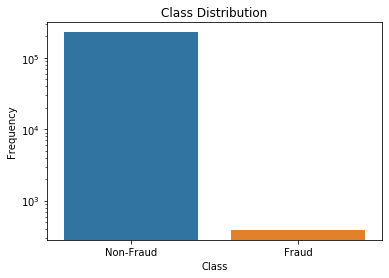

In [36]:
counts = credit['Class'].value_counts()
labels = ['Non-Fraud', 'Fraud']
ax = sns.barplot(x=labels, y=counts, log=True)
ax.set(xlabel='Class', ylabel='Frequency', title='Class Distribution');

## Time

Observe that there are two days worth of data.

In [70]:
max_seconds = credit['Time'].max()
max_seconds

172792.0

In [204]:
day_seconds = 24 * 60 * 60

predicate = lambda x: x - day_seconds <= max_seconds
iterable = (day_seconds * i for i in itertools.count())
tuple(itertools.takewhile(predicate, iterable))

(0, 86400, 172800)

When graphed, we can clearly see a two day cycle of how many transactions are undergone during the day. I'll assume that the peaks are during daytime and the valleys are at night.

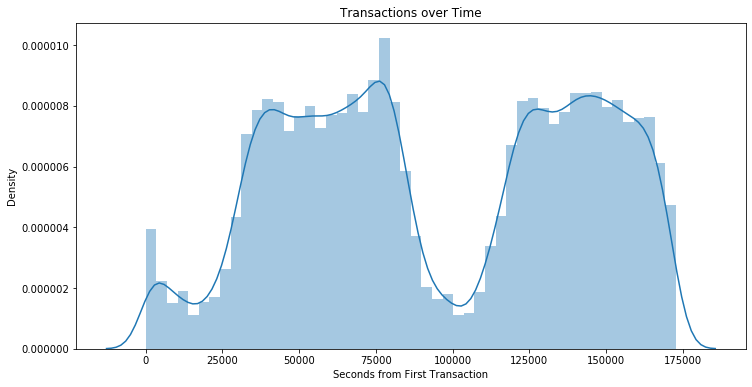

In [145]:
plt.figure(figsize=(12, 6))
ax = sns.distplot(credit['Time'])
ax.set(xlabel='Seconds from First Transaction', ylabel='Density', title='Transactions over Time');

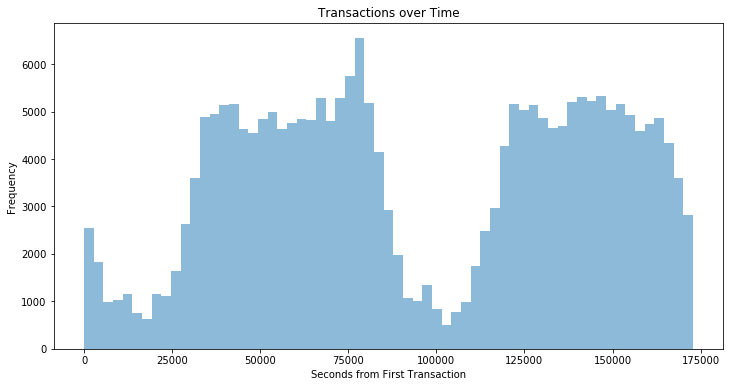

In [191]:
bins = len(np.histogram_bin_edges(time_counts, bins='auto'))

plt.figure(figsize=(12, 6))
plt.hist(credit['Time'], bins=bins, alpha=0.5)
plt.xlabel('Seconds from First Transaction')
plt.ylabel('Frequency')
plt.title('Transactions over Time');

Let's regularize this to have a column for the hour of the day rather than time from the first transaction. Assume midnight occurs at the minimums.

In [192]:
time_counts = credit['Time']
cuts = pd.cut(time_counts, bins).value_counts()
cuts[cuts < 1000]

(106966.476, 109709.206]    984
(5485.46, 8228.19]          981
(98738.286, 101481.016]     834
(104223.746, 106966.476]    780
(13713.651, 16456.381]      762
(16456.381, 19199.111]      633
(101481.016, 104223.746]    499
Name: Time, dtype: int64

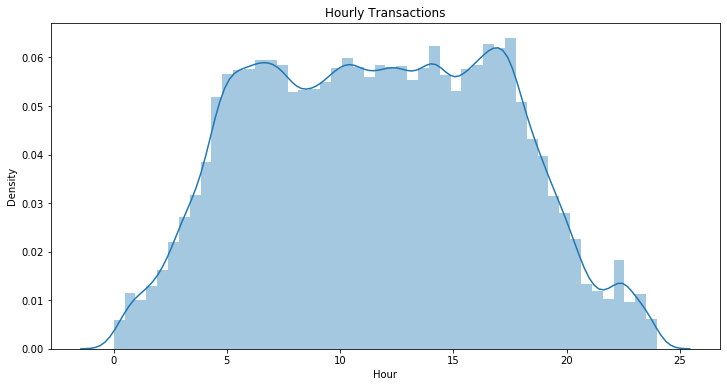

In [207]:
hour_seconds = 60 * 60
midnight = int(cuts.index[-1].mid)
credit['Hour'] = ((credit['Time'] - midnight) % day_seconds) / hour_seconds

plt.figure(figsize=(12, 6))
ax = sns.distplot(credit['Hour'])
ax.set(xlabel='Hour', ylabel='Density', title='Hourly Transactions');

In [62]:
print(seconds, seconds * 2)
credit['Time'].describe()
(credit['Time'] % seconds).describe()

86400 172800


count    227845.000000
mean      52324.481898
std       21054.009473
min           0.000000
25%       38139.000000
50%       54032.000000
75%       69581.000000
max       86398.000000
Name: Time, dtype: float64

In [56]:
is_fraud = credit['Class'] == min_cls_label

fraud = credit[is_fraud]
f_desc = fraud.describe()['Amount']
f_desc.name = 'Fraud'

notfraud = credit[~is_fraud]
nf_desc = notfraud.describe()['Amount']
nf_desc.name = 'Not Fraud'

pd.concat([f_desc, nf_desc], axis=1)

,Fraud,Not Fraud
count,391.000000,227454.000000
mean,125.638107,88.566586
std,263.658004,248.005952
min,0.000000,0.000000
25%,1.000000,5.740000
50%,14.460000,22.000000
75%,106.270000,77.500000
max,2125.870000,19656.530000


## Outliers
--------------
We will start by looking for outliers in non-fraud data. It is likely that these will be confused with fraudulent data points, since their transaction amounts are statisitcally different from both non-fraud inliers and all the non-fraud data.

In [57]:
lof = LocalOutlierFactor(contamination='auto')
lof_preds = lof.fit_predict(notfraud)

inliers = notfraud[lof_preds == 1]
in_desc = inliers.describe()['Amount']
in_desc.name = 'NF Inlier'

outliers = notfraud[lof_preds == -1]
out_desc = outliers.describe()['Amount']
out_desc.name = 'NF Outlier'

pd.concat([nf_desc, in_desc, out_desc], axis=1)

,Not Fraud,NF Inlier,NF Outlier
count,227454.000000,223656.000000,3798.000000
mean,88.566586,81.231710,520.501561
std,248.005952,191.953976,1150.792713
min,0.000000,0.000000,0.000000
25%,5.740000,5.490000,45.765000
50%,22.000000,21.200000,145.490000
75%,77.500000,74.990000,393.475000
max,19656.530000,5114.100000,19656.530000


Visually, we can also see that the outliers KDE plot is more skewed to the right.

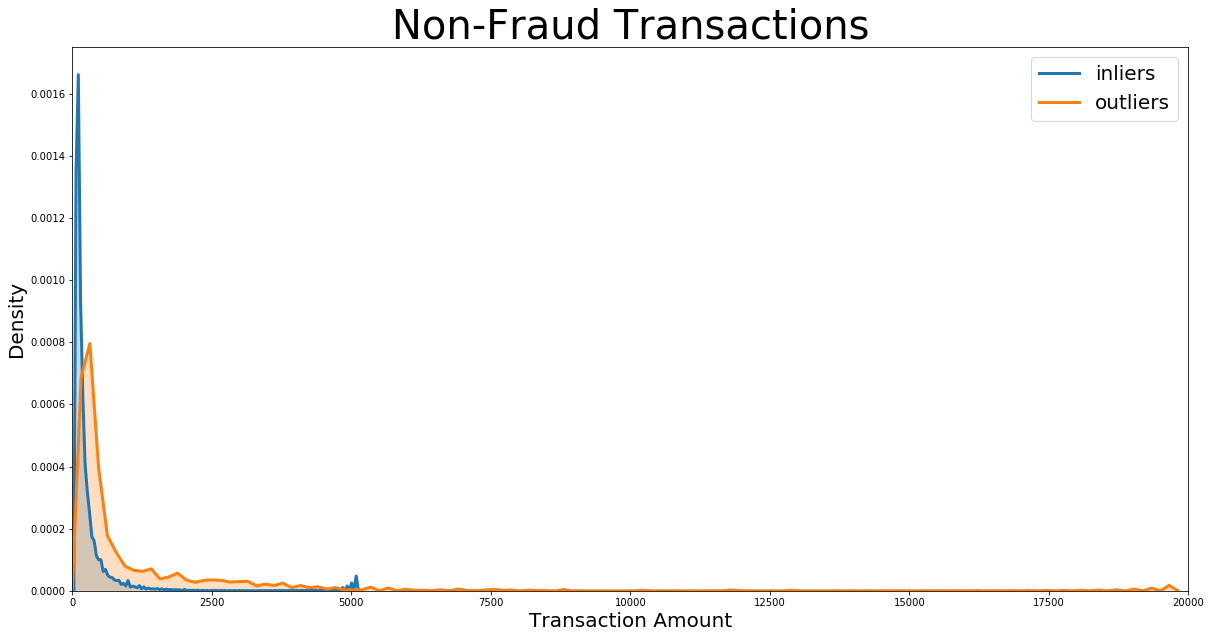

In [114]:
#TODO: remove this since I did full sweep with function below

plt.figure(figsize=(20, 10))

sns.kdeplot(inliers['Amount'], label='inliers', linewidth=3, shade=True)
sns.kdeplot(outliers['Amount'], label='outliers', linewidth=3, shade=True)

plt.xlim([0, round(notfraud['Amount'].max(), -3)])
plt.ylim([0, 0.00175])

plt.xlabel('Transaction Amount', fontdict=dict(fontsize=20))
plt.ylabel('Density', fontdict=dict(fontsize=20))

plt.legend(prop={'size': 20})
plt.title('Non-Fraud Transactions', fontdict=dict(fontsize=40));

We will remove these non-fraud outliers from the dataset to better detect fraudulent activity. This is acceptable since it only accounts for 1.6% of the dataset.

In [60]:
print(f"Outliers to non-fraud: {len(outliers) / len(notfraud)}")
print(f"Outliers to all data: {len(outliers) / len(credit)}")

Outliers to non-fraud: 0.016697881769500645
Outliers to all data: 0.016669226886699293


Outliers on entire data set

In [148]:
lof = LocalOutlierFactor(contamination='auto')
lof_preds = lof.fit_predict(credit)

is_outlier = lof_preds == -1

In [149]:
credit[is_outlier & is_fraud].shape

(69, 31)

In [150]:
credit[~is_outlier & is_fraud].shape

(322, 31)

In [151]:
credit[is_outlier & ~is_fraud].shape

(3776, 31)

In [152]:
credit[~is_outlier & ~is_fraud].shape

(223678, 31)

### Non-Fraud Outliers vs Fraud Outliers
- fraud is more jagged
    - perhaps more "regular" transaction amounts (eg 150.00 vs 156.87)?
- fraud has a __lot__ of transactions close to 0

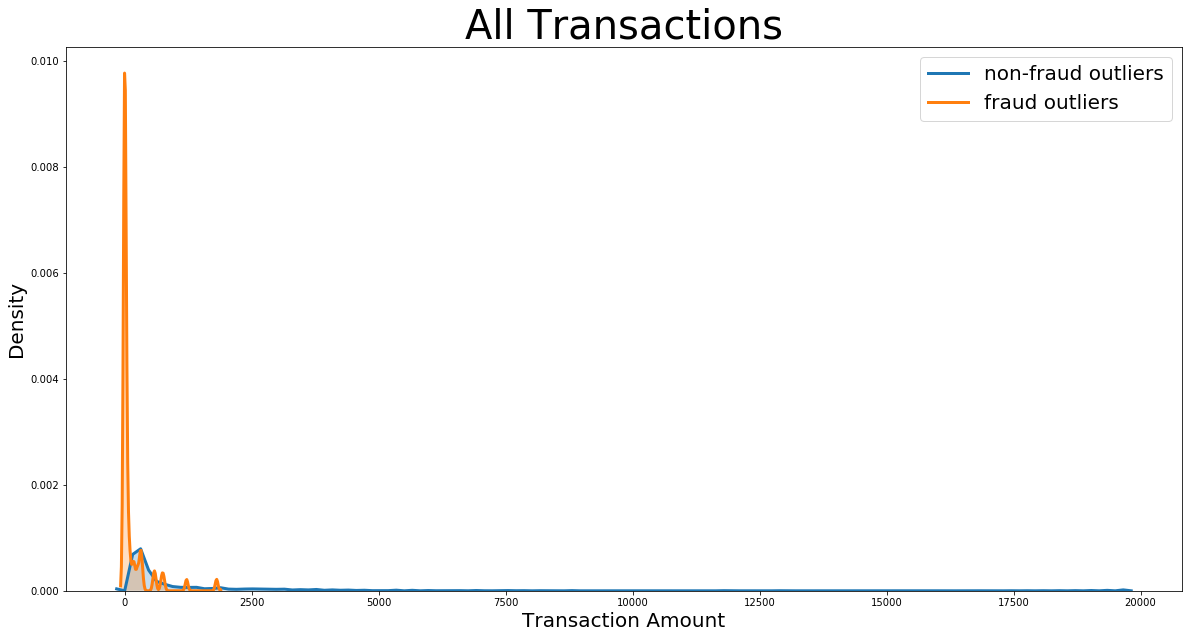

In [154]:
plt.figure(figsize=(20, 10))

sns.kdeplot(credit[is_outlier & ~is_fraud]['Amount'], label='non-fraud outliers', linewidth=3, shade=True)
sns.kdeplot(credit[is_outlier & is_fraud]['Amount'], label='fraud outliers', linewidth=3, shade=True)

plt.xlabel('Transaction Amount', fontdict=dict(fontsize=20))
plt.ylabel('Density', fontdict=dict(fontsize=20))

plt.legend(prop={'size': 20})
plt.title('All Transactions', fontdict=dict(fontsize=40));

In [140]:
def display_outliers(df, title, column='Amount'):
    lof = LocalOutlierFactor(contamination='auto')
    pred = lof.fit_predict(df)
    
    is_outlier = (pred == -1)
    
    plt.figure(figsize=(20, 10))

    sns.kdeplot(df[~is_outlier][column], label='inliers', linewidth=3, shade=True)
    sns.kdeplot(df[is_outlier][column], label='outliers', linewidth=3, shade=True)

    plt.xlabel('Transaction Amount', fontdict=dict(fontsize=20))
    plt.ylabel('Density', fontdict=dict(fontsize=20))

    plt.legend(prop={'size': 20})
    plt.title(title, fontdict=dict(fontsize=40));

Fraud outlier and inlier KDE distributions overlap very closely.
- Both have peaks around 0.
- Outlier has slightly lower peak.
- Inlier has longer right tail.

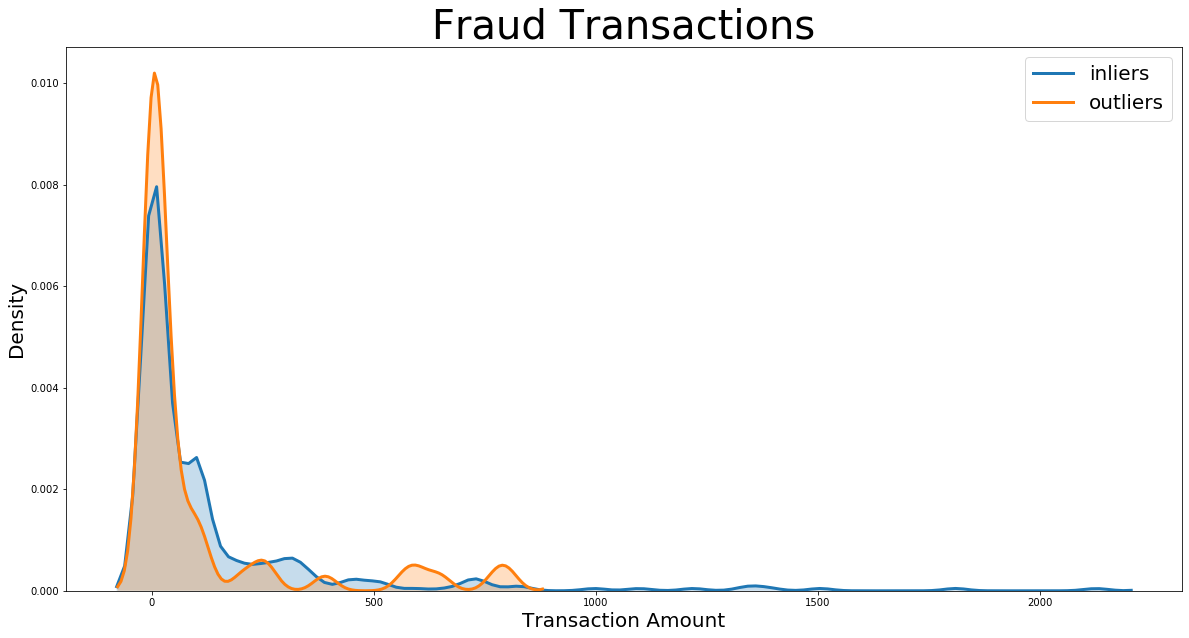

In [141]:
display_outliers(fraud, 'Fraud Transactions')

Non-fraud outlier and inlier distributions are quite different than the fraud case.
- Outlier peak is not close to 0
- Inlier peak is half that of the outlier peak.
- Outlier has a huge right skew.

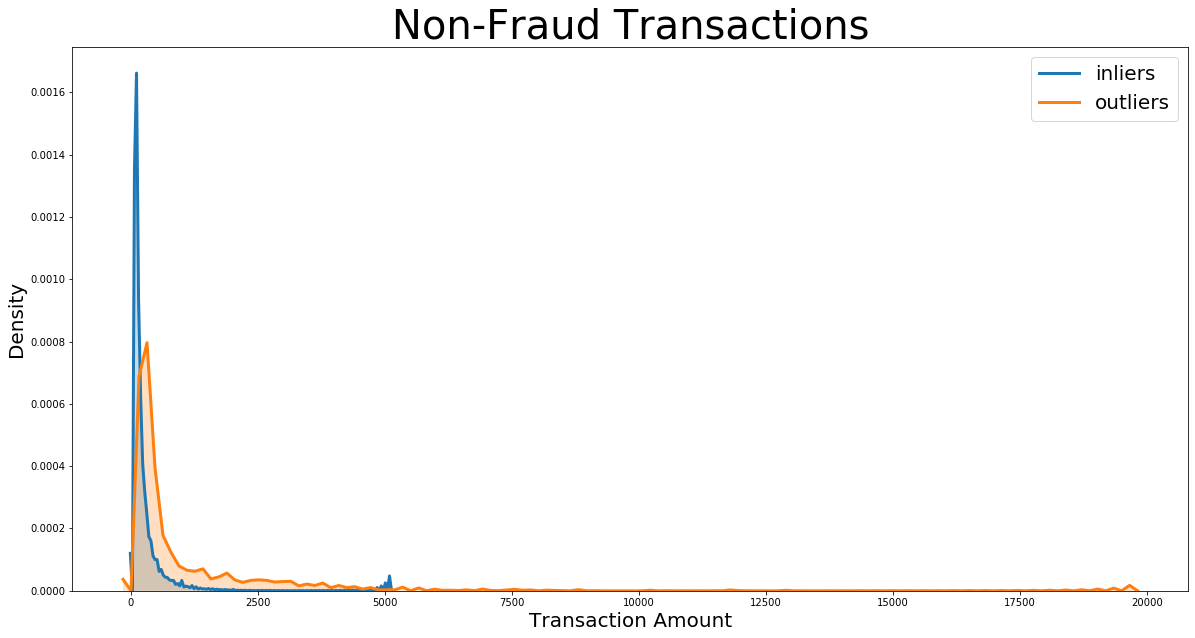

In [142]:
display_outliers(notfraud, 'Non-Fraud Transactions')